# Array2DScanAnalyzer with 'variational analyzer'

This notebook demonstrates shows how to perform two different ImageAnalzyers for a given camera. This example is strongly coupled to functionality in ImageAnalysis.

The idea here is that it may be desireable to perform more than one ImageAnalysis for a camera. In this case, we use two instances of BeamAnalyzer. The standar_analyzer performs a basic workflow of background subtraction. A helper method from BeamAnalyzer allows easy instantiation an analyzer for the same device with different processing settings. In this example, the second analyzer implements 'variation' analysis which gets saved and stored with a 'variation' in teh suffix

In [1]:
import logging

from geecs_data_utils import ScanData, ScanPaths, ScanTag
from scan_analysis.base import ScanAnalyzerInfo as Info
from scan_analysis.execute_scan_analysis import instantiate_scan_analyzer
from scan_analysis.analyzers.common.array2D_scan_analysis import Array2DScanAnalyzer

# import the desired ImageAnalyzer
from image_analysis.offline_analyzers.beam_analyzer import (
    BeamAnalyzer,
    create_variation_analyzer,
)

# BeamAnalyzer uses a configuration file for instantiation and use. So,
# we need to set the config path. But, any type of ImageAnalzyer can be used.
from geecs_data_utils.config_roots import image_analysis_config

# Set the logging level. Can set to INFO or DEBUG to get more detail about the
# actual execution
logging.getLogger("image_analysis").setLevel(logging.WARNING)
logging.getLogger("scan_analysis").setLevel(logging.WARNING)
logging.getLogger("geecs_data_utils").setLevel(logging.WARNING)

image_analysis_config.set_base_dir(ScanPaths.paths_config.image_analysis_configs_path)

2025-12-08 13:00:46,430 - scan_analysis.execute_scan_analysis - WARNING - Docgen import failed ('script'); disabling.


Failed to load config file from: D:\Users\sbarber.BELLAAPPSERVER\Documents\GitHub\GEECS-Plugins\LogMaker4GoogleDocs\logmaker_4_googledocs\config.ini


WindowsPath('D:/Users/sbarber.BELLAAPPSERVER/Documents/GitHub/GEECS-Plugins-Configs/image_analysis_configs')

Instantiate the two different analyzers. The first 'standard_analyzer' directly uses the stored config. The 'variation_analyzer' performs a dynamic background subtraction technique. It calculates the pixel-wise 'avg' based on a percentile calculation. This is stored as the background that which is then subtracted from each image. 'additional_constant' applies an additional background subtraction as desired

In [2]:
dev_name = "UC_Amp4_IR_input"
standard_analyzer = BeamAnalyzer(camera_config_name=dev_name)
variation_analyzer = create_variation_analyzer(
    camera_config_name=dev_name, percentile=15, additional_constant=5
)

In [3]:
import time

t0 = time.monotonic()
year = 2025
month = 2
day = 20
number = 14
experiment = "Undulator"
test_tag = ScanTag(
    year=year, month=month, day=day, number=number, experiment=experiment
)

standard_analyzer_info = Info(
    scan_analyzer_class=Array2DScanAnalyzer,
    requirements={dev_name},
    device_name=dev_name,
    scan_analyzer_kwargs={"image_analyzer": standard_analyzer},
)

variational_analyzer_info = Info(
    scan_analyzer_class=Array2DScanAnalyzer,
    requirements={dev_name},
    device_name=dev_name,
    scan_analyzer_kwargs={"image_analyzer": variation_analyzer},
)


variational_scan_analyzer = instantiate_scan_analyzer(
    scan_analyzer_info=variational_analyzer_info
)
variational_scan_analyzer.run_analysis(scan_tag=test_tag)

standard_scan_analyzer = instantiate_scan_analyzer(
    scan_analyzer_info=standard_analyzer_info
)
standard_scan_analyzer.run_analysis(scan_tag=test_tag)

t1 = time.monotonic()
print(f"execution time: {t1 - t0}")

2025-12-08 13:00:47,818 - scan_analysis.base - WARNING - No parameter varied during the scan, setting noscan flag.
2025-12-08 13:01:51,067 - scan_analysis.base - WARNING - No parameter varied during the scan, setting noscan flag.


execution time: 121.171999999322


We can use the variational image_analyzer to inspect a single image

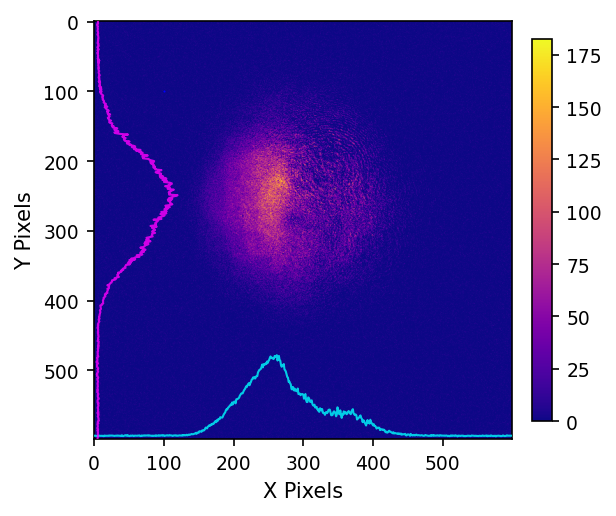

(<Figure size 600x600 with 2 Axes>,
 <Axes: xlabel='X Pixels', ylabel='Y Pixels'>)

In [4]:
sd = ScanData.from_date(
    year=year, month=month, day=day, number=number, experiment=experiment
)

file_path = sd.data_frame[f"{dev_name}_expected_path"][9]

%matplotlib inline
result = variation_analyzer.analyze_image_file(file_path)
variation_analyzer.visualize(result)